In [1]:
import pandas as pd
import json
import numpy as np
import os

In [ ]:
dir_ = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/feedback_evaluations'

file2name = {
    'scores_df-vqa_strict_instruction.csv': 'VQA Llama-3.2-11b Base (Strict Instruction)',
    'scores_df-no_iat-yes_frames.csv': 'No IAT, w/ Frames',
    'scores_df-iat=pred-yes_frames.csv': 'IAT Predictions, w/ Frames',
    'scores_df-iat=pred-no_frames-final.csv': 'IAT Predictions, wo/frames, Final',
}

dfs = {}
for f in os.listdir(dir_):
    if not f.endswith('.csv'):
        continue
    path = os.path.join(dir_, f)
    df = pd.read_csv(path)
    if f in file2name:
        dfs[file2name[f]] = df
dfs = {name: dfs[name] for name in file2name.values()}
dfs.keys()

dict_keys(['VQA Llama-3.2-11b Base (Strict Instruction)', 'No IAT, w/ Frames', 'IAT Predictions, w/ Frames', 'IAT Predictions, wo/frames, Final'])

In [3]:
import collections
import math
import numpy as np

def calculate_wer(string1, string2):
    reference = string1
    hypothesis = string2

    ref_words = reference.split()
    hyp_words = hypothesis.split()
    
    dp = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
    
    for i in range(len(ref_words) + 1):
        dp[i][0] = i
    for j in range(len(hyp_words) + 1):
        dp[0][j] = j
        
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            cost = 0 if ref_words[i-1] == hyp_words[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,        # Deletion
                           dp[i][j-1] + 1,        # Insertion
                           dp[i-1][j-1] + cost)   # Substitution
                           
    wer = dp[len(ref_words)][len(hyp_words)] / len(ref_words)
    return wer

def calculate_bleu(string1, string2):
    reference_str = string1
    candidate_str = string2

    def get_ngrams(segment, max_order):
        ngram_counts = collections.defaultdict(int)
        for order in range(1, max_order + 1):
            for i in range(len(segment) - order + 1):
                ngram = tuple(segment[i:i+order])
                ngram_counts[ngram] += 1
        return ngram_counts

    def compute_bleu(reference, candidate, max_order=4, smooth=False):
        candidate_tokens = candidate.split()
        reference_tokens = reference.split()
        
        clipped_counts = collections.defaultdict(int)
        candidate_ngrams = get_ngrams(candidate_tokens, max_order)
        reference_ngrams = get_ngrams(reference_tokens, max_order)

        for ngram, count in candidate_ngrams.items():
            clipped_counts[ngram] = min(count, reference_ngrams[ngram])

        precision_scores = []
        for order in range(1, max_order + 1):
            correct = 0
            total = 0
            for ngram, count in candidate_ngrams.items():
                if len(ngram) == order:
                    correct += clipped_counts[ngram]
                    total += count
            
            if total > 0:
                precision = correct / total
            else:
                precision = 0.0
            precision_scores.append(precision)

        candidate_len = len(candidate_tokens)
        reference_len = len(reference_tokens)

        if candidate_len > reference_len:
            bp = 1.0
        elif candidate_len == 0:
            bp = 0.0
        else:
            bp = math.exp(1 - reference_len / candidate_len)

        weights = [1.0/max_order] * max_order
        
        score = 0.0
        for i, precision in enumerate(precision_scores):
            if precision > 0:
                score += weights[i] * math.log(precision)
            elif smooth:
                 score += weights[i] * math.log(1e-12)

        if any(p == 0 for p in precision_scores) and not smooth:
             return 0.0

        return bp * math.exp(score)

    return compute_bleu(reference_str, candidate_str)

def calculate_rouge(string1, string2):
    reference = string1
    summary = string2

    def get_unigrams(text):
        return collections.Counter(text.split())

    ref_unigrams = get_unigrams(reference)
    summary_unigrams = get_unigrams(summary)

    overlap_count = 0
    for unigram in summary_unigrams:
        overlap_count += min(summary_unigrams[unigram], ref_unigrams[unigram])
    
    if len(ref_unigrams) == 0:
        return 0.0
        
    recall = overlap_count / sum(ref_unigrams.values())
    
    return recall

def summarize_eval_scores(scores: list[int]) -> dict:
    return {
        'mean': scores.mean(),
        'mean-std': scores.std(),
        'median': scores.median(),
        '% >= 3': (scores >= 3).mean() * 100,
        '% >= 4': (scores >= 4).mean() * 100,
        '% at 1': (scores == 1).mean() * 100,
        'N': len(scores),
    }
    
def calculate_wer_with_std(reference_hyp_pairs):
    wer_scores = []
    
    for reference, hypothesis in reference_hyp_pairs:
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        
        dp = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
        
        for i in range(len(ref_words) + 1):
            dp[i][0] = i
        for j in range(len(hyp_words) + 1):
            dp[0][j] = j
            
        for i in range(1, len(ref_words) + 1):
            for j in range(1, len(hyp_words) + 1):
                cost = 0 if ref_words[i-1] == hyp_words[j-1] else 1
                dp[i][j] = min(dp[i-1][j] + 1,        # Deletion
                               dp[i][j-1] + 1,        # Insertion
                               dp[i-1][j-1] + cost)   # Substitution
                               
        wer = dp[len(ref_words)][len(hyp_words)] / len(ref_words)
        wer_scores.append(wer)
        
    avg_wer = np.mean(wer_scores)
    std_dev_wer = np.std(wer_scores)
    
    return avg_wer, std_dev_wer

def calculate_rouge_with_std(reference_summary_pairs):
    rouge_scores = []

    def get_unigrams(text):
        if not isinstance(text, str):
            # Handle non-string input gracefully if needed
            return collections.Counter()
        return collections.Counter(text.split())

    for reference, summary in reference_summary_pairs:
        ref_unigrams = get_unigrams(reference)
        summary_unigrams = get_unigrams(summary)

        overlap_count = 0
        for unigram in summary_unigrams:
            overlap_count += min(summary_unigrams[unigram], ref_unigrams[unigram])
        
        # Avoid division by zero if the reference is empty
        if sum(ref_unigrams.values()) == 0:
            recall = 0.0
        else:
            recall = overlap_count / sum(ref_unigrams.values())
        
        rouge_scores.append(recall)

    # Calculate the mean and standard deviation of the scores
    avg_rouge = np.mean(rouge_scores)
    std_dev_rouge = np.std(rouge_scores)
    
    return avg_rouge, std_dev_rouge


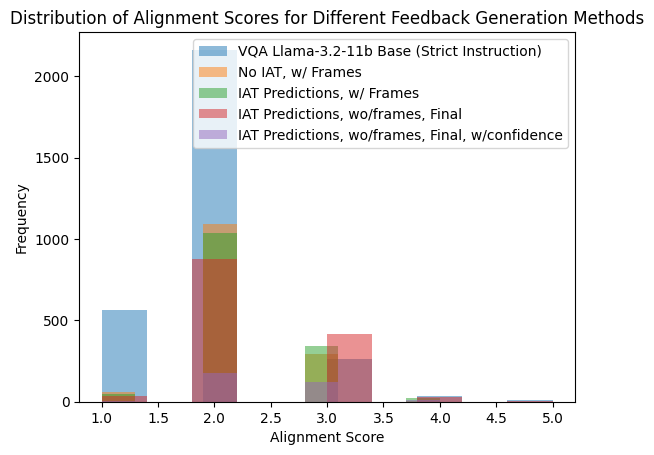

In [106]:
import matplotlib.pyplot as plt

val_splits = [
    pd.read_csv(f'/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/iat_predictor_splits/val{i}.csv')
    for i in range(1, 6)
]

df = dfs['IAT Predictions, wo/frames, Final']
df_conf_rows = []
for i in range(len(df)):
    row = df.iloc[i]
    dont_add_row = False
    if row['instrument_conf'] != 'NONE' and eval(row['instrument_conf']) < 0.4:
        dont_add_row = True
    if row['action_conf'] != 'NONE' and eval(row['action_conf']) < 0.4:
        dont_add_row = True
    if row['tissue_conf'] != 'NONE' and eval(row['tissue_conf']) < 0.05:
        dont_add_row = True
    if not dont_add_row:
        df_conf_rows.append(row)
df_conf_rows = pd.DataFrame(df_conf_rows)
dfs['IAT Predictions, wo/frames, Final, w/confidence'] = df_conf_rows

feedback_df = pd.read_csv('/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/feedback_generations/feedback_df-iat=pred-no_frames-final.csv')
rows = []
for name, df in dfs.items():
    tmp_df = df.copy().rename(columns={'dialogue': 'ground_truth', 'feedback': 'prediction'})
    if 'instrument' not in tmp_df.columns:
        tmp_df = tmp_df.merge(feedback_df, on='cvid', how='left')
    tmp_df = tmp_df[(tmp_df['instrument'] != 'NONE') |
                            (tmp_df['action'] != 'NONE') |
                            (tmp_df['tissue'] != 'NONE')]
    
    scores = tmp_df['score']
    plt.hist(scores, bins=10, alpha=0.5, label=name)
    plt.legend()
    
    ground_truths = tmp_df['ground_truth'].tolist()
    predictions = tmp_df['prediction'].tolist()
    
    inputs = []
    for i in range(len(ground_truths)):
        if not pd.isna(predictions[i]) and not pd.isna(ground_truths[i]):
            inputs.append((ground_truths[i], predictions[i]))
    
    avg_wer, std_wer = calculate_wer_with_std(inputs)
    avg_rouge, std_rouge = calculate_rouge_with_std(inputs)
    
    row_dict = {
        'Condition': f'{name}',
    }
    
    eval_score_summary = summarize_eval_scores(scores)
    
    # calculate stds from val splits
    val_mean_scores = []
    val_wer_scores = []
    val_rouge_scores = []
    for val_split in val_splits:
        tmp_df2 = tmp_df[tmp_df['cvid'].isin(val_split['cvid'])]
        val_mean_scores.append(tmp_df2['score'].mean())
        
        tmp_ground_truths = tmp_df2['ground_truth'].tolist()
        tmp_predictions = tmp_df2['prediction'].tolist()
        
        tmp_inputs = []
        for i in range(len(tmp_ground_truths)):
            if not pd.isna(tmp_predictions[i]) and not pd.isna(tmp_ground_truths[i]):
                tmp_inputs.append((tmp_ground_truths[i], tmp_predictions[i]))
        
        val_wer_scores.append(calculate_wer_with_std(tmp_inputs)[0])
        val_rouge_scores.append(calculate_rouge_with_std(tmp_inputs)[0])
        
    row_dict.update(eval_score_summary)
    row_dict.update({
        'mean-std': f"{np.std(val_mean_scores):.2f}",
        'WER': avg_wer,
        # 'WER-std': std_wer,
        'WER-std': f"{np.std(val_wer_scores):.2f}",
        # 'BLEU': avg_bleu,
        'ROUGE': avg_rouge,
        # 'ROUGE-std': std_rouge,
        'ROUGE-std': f"{np.std(val_rouge_scores):.2f}",
    })
    
    rows.append(row_dict)



plt.xlabel('Alignment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Alignment Scores for Different Feedback Generation Methods')
plt.show()

In [115]:
tmp_df = dfs['IAT Predictions, wo/frames, Final'].copy()
new_rows = []
for i in range(len(tmp_df)):
    row = tmp_df.iloc[i]
    dont_add_row = False
    if row['instrument_conf'] != 'NONE' and eval(row['instrument_conf']) < 0.4:
        dont_add_row = True
    if row['action_conf'] != 'NONE' and eval(row['action_conf']) < 0.4:
        dont_add_row = True
    if row['tissue_conf'] != 'NONE' and eval(row['tissue_conf']) < 0.05:
        dont_add_row = True
    if not dont_add_row:
        new_rows.append(row)

new_df = pd.DataFrame(new_rows)
summarize_eval_scores(new_df['score'])

{'mean': 2.439739413680782,
 'mean-std': 0.5706182266901643,
 'median': 2.0,
 '% >= 3': 42.01954397394137,
 '% >= 4': 2.9315960912052117,
 '% at 1': 0.9771986970684038,
 'N': 307}

In [107]:
analysis_df = pd.DataFrame(rows)
analysis_df.round(3)

,Condition,mean,mean-std,median,% >= 3,% >= 4,% at 1,N,WER,WER-std,ROUGE,ROUGE-std
0,VQA Llama-3.2-11b Base (Strict Instruction),1.933,0.03,2.0,10.125,1.418,18.536,3032,11.011,0.99,0.085,0.02
1,"No IAT, w/ Frames",2.168,0.02,2.0,20.621,0.345,4.207,1450,5.049,0.27,0.109,0.00
2,"IAT Predictions, w/ Frames",2.232,0.02,2.0,25.052,1.518,3.382,1449,4.271,0.24,0.106,0.00
3,"IAT Predictions, wo/frames, Final",2.326,0.02,2.0,32.771,2.419,2.713,1364,4.181,0.22,0.130,0.00
4,"IAT Predictions, wo/frames, Final, w/confidence",2.440,0.03,2.0,42.020,2.932,0.977,307,3.468,0.43,0.181,0.01
